# Drivers of Log Error in Zillow

# Executive Summary <br>
- Goal: Discover predictive features for log error in Zillow for single residential properties
- Data: Zillow SQL Database was used to obtain single residential properties
- Significant Findings: bedrooms, bathrooms, area(sqft), and location were the most significant features
- Recomendation: Further work is needed to create models that outperform the mean baseline model

In [1]:
# Data wrangling
import numpy as np
import pandas as pd

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Statistical analysis
import scipy.stats as stats

# Modeling
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.cluster import KMeans, dbscan 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score

# Custom user files
# Credentials for logging into Codeup SQL server
from env import user, password, host
# User created functions for wrangling data
import wrangle

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import os

# Setting up display options for pandas
pd.set_option('display.max_columns', 80)
pd.set_option("precision", 3)

# Acquire Data

In [2]:
df = wrangle.get_zillow_data()
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,3.363e+07,-1.179e+08,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1.023e+06,2016.0,537569.0,11013.72,NaN,NaN,6.059e+13,0.026,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,3.445e+07,-1.193e+08,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,4.640e+05,2016.0,376000.0,5672.48,NaN,NaN,6.111e+13,0.056,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,3.389e+07,-1.178e+08,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,5.648e+05,2016.0,479489.0,6488.30,NaN,NaN,6.059e+13,0.005,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,3.425e+07,-1.182e+08,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,1.451e+05,2016.0,36225.0,1777.51,NaN,NaN,6.037e+13,-0.103,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,3.419e+07,-1.184e+08,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,1.194e+05,2016.0,45726.0,1533.89,NaN,NaN,6.037e+13,0.007,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
df.shape

(77381, 68)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,77381.0,1.495e+06,8.609e+05,3.490e+02,7.521e+05,1.498e+06,2.241e+06,2.982e+06
parcelid,77381.0,1.301e+07,3.481e+06,1.071e+07,1.154e+07,1.253e+07,1.421e+07,1.677e+08
airconditioningtypeid,24953.0,1.813e+00,2.968e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.300e+01
architecturalstyletypeid,206.0,7.388e+00,2.735e+00,2.000e+00,7.000e+00,7.000e+00,7.000e+00,2.100e+01
basementsqft,50.0,6.797e+02,6.897e+02,3.800e+01,2.730e+02,5.150e+02,7.965e+02,3.560e+03
bathroomcnt,77381.0,2.299e+00,9.967e-01,0.000e+00,2.000e+00,2.000e+00,3.000e+00,1.800e+01
bedroomcnt,77381.0,3.053e+00,1.139e+00,0.000e+00,2.000e+00,3.000e+00,4.000e+00,1.600e+01
buildingclasstypeid,15.0,3.933e+00,2.582e-01,3.000e+00,4.000e+00,4.000e+00,4.000e+00,4.000e+00
buildingqualitytypeid,49672.0,6.535e+00,1.722e+00,1.000e+00,6.000e+00,6.000e+00,8.000e+00,1.200e+01
calculatedbathnbr,76772.0,2.317e+00,9.798e-01,1.000e+00,2.000e+00,2.000e+00,3.000e+00,1.800e+01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77380
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77381 non-null  int64  
 1   parcelid                      77381 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77381 non-null  float64
 6   bedroomcnt                    77381 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49672 non-null  float64
 9   calculatedbathnbr             76772 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet  77185 non-null  float64
 13  f

In [6]:
df.isnull().sum().sort_values(ascending=False)

buildingclassdesc        77366
buildingclasstypeid      77366
finishedsquarefeet13     77340
storytypeid              77331
basementsqft             77331
                         ...  
latitude                     0
fips                         0
bedroomcnt                   0
bathroomcnt                  0
propertylandusetypeid        0
Length: 68, dtype: int64

# Prepare Data

In [7]:
df = wrangle.wrangle_zillow()
df.head()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,logerror,age_bin,taxrate,acres,acres_bin,tax_value_bin,land_tax_value_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,land_dollar_sqft_bin,bath_bed_ratio
0,3.5,4.0,3100.0,6059,3.363e+07,-1.179e+08,19.0,485713.0,1.023e+06,537569.0,11013.72,0.026,10-20,1.076,0.103,0.1,"$5,000,000","$650,000",0.7,156.682,0.5,119.301,100-249,0.875
1,1.0,2.0,1465.0,6111,3.445e+07,-1.193e+08,50.0,88000.0,4.640e+05,376000.0,5672.48,0.056,40-50,1.223,0.290,0.3,"$550,000","$450,000",0.3,60.068,0.2,29.730,20-49,0.500
2,2.0,3.0,1243.0,6059,3.389e+07,-1.178e+08,55.0,85289.0,5.648e+05,479489.0,6488.30,0.005,50-60,1.149,0.194,0.2,"$650,000","$650,000",0.2,68.615,0.2,56.865,50-99,0.667
3,3.0,4.0,2376.0,6037,3.425e+07,-1.182e+08,47.0,108918.0,1.451e+05,36225.0,1777.51,-0.103,40-50,1.225,0.299,0.3,"$150,000","< $50,000",0.5,45.841,0.1,2.778,1,0.750
4,3.0,3.0,1312.0,6037,3.419e+07,-1.184e+08,53.0,73681.0,1.194e+05,45726.0,1533.89,0.007,50-60,1.285,6.395,0.6,"$150,000","< $50,000",0.3,56.159,0.2,0.164,0,1.000


Feature engineering: <br>
- taxrate
- bath/bed ratio
- acres (lot size in square feet / 43560)
- dollar per square foot
- bins for age and square feet

In [8]:
df.shape

(66828, 24)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66828 entries, 0 to 77380
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   bathrooms                  66828 non-null  float64 
 1   bedrooms                   66828 non-null  float64 
 2   square_feet                66828 non-null  float64 
 3   fips                       66828 non-null  int64   
 4   latitude                   66828 non-null  float64 
 5   longitude                  66828 non-null  float64 
 6   age                        66828 non-null  float64 
 7   structure_tax_value        66828 non-null  float64 
 8   tax_value                  66828 non-null  float64 
 9   land_tax_value             66828 non-null  float64 
 10  taxamount                  66828 non-null  float64 
 11  logerror                   66828 non-null  float64 
 12  age_bin                    66828 non-null  category
 13  taxrate                    6682

In [10]:
df.isna().sum()

bathrooms                    0
bedrooms                     0
square_feet                  0
fips                         0
latitude                     0
longitude                    0
age                          0
structure_tax_value          0
tax_value                    0
land_tax_value               0
taxamount                    0
logerror                     0
age_bin                      0
taxrate                      0
acres                        0
acres_bin                    0
tax_value_bin                0
land_tax_value_bin           0
sqft_bin                     0
structure_dollar_per_sqft    0
structure_dollar_sqft_bin    0
land_dollar_per_sqft         0
land_dollar_sqft_bin         0
bath_bed_ratio               0
dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,66828.0,2.206e+00,0.845,1.000e+00,2.000e+00,2.000e+00,3.000e+00,7.000e+00
bedrooms,66828.0,2.985e+00,0.972,1.000e+00,2.000e+00,3.000e+00,4.000e+00,7.000e+00
square_feet,66828.0,1.678e+03,772.875,5.000e+02,1.156e+03,1.486e+03,1.990e+03,8.615e+03
fips,66828.0,6.049e+03,21.025,6.037e+03,6.037e+03,6.037e+03,6.059e+03,6.111e+03
latitude,66828.0,3.401e+07,269101.031,3.334e+07,3.381e+07,3.401e+07,3.418e+07,3.482e+07
longitude,66828.0,-1.182e+08,362796.653,-1.195e+08,-1.184e+08,-1.182e+08,-1.179e+08,-1.176e+08
age,66828.0,4.795e+01,22.771,1.000e+00,3.100e+01,4.700e+01,6.300e+01,1.390e+02
structure_tax_value,66828.0,1.649e+05,137443.402,4.400e+01,8.179e+04,1.305e+05,2.030e+05,2.860e+06
tax_value,66828.0,4.053e+05,291617.572,3.254e+03,1.984e+05,3.450e+05,5.330e+05,3.574e+06
land_tax_value,66828.0,2.404e+05,200259.309,1.196e+03,7.874e+04,1.947e+05,3.440e+05,1.000e+06


Text(0.5, 1.0, 'Logerror')

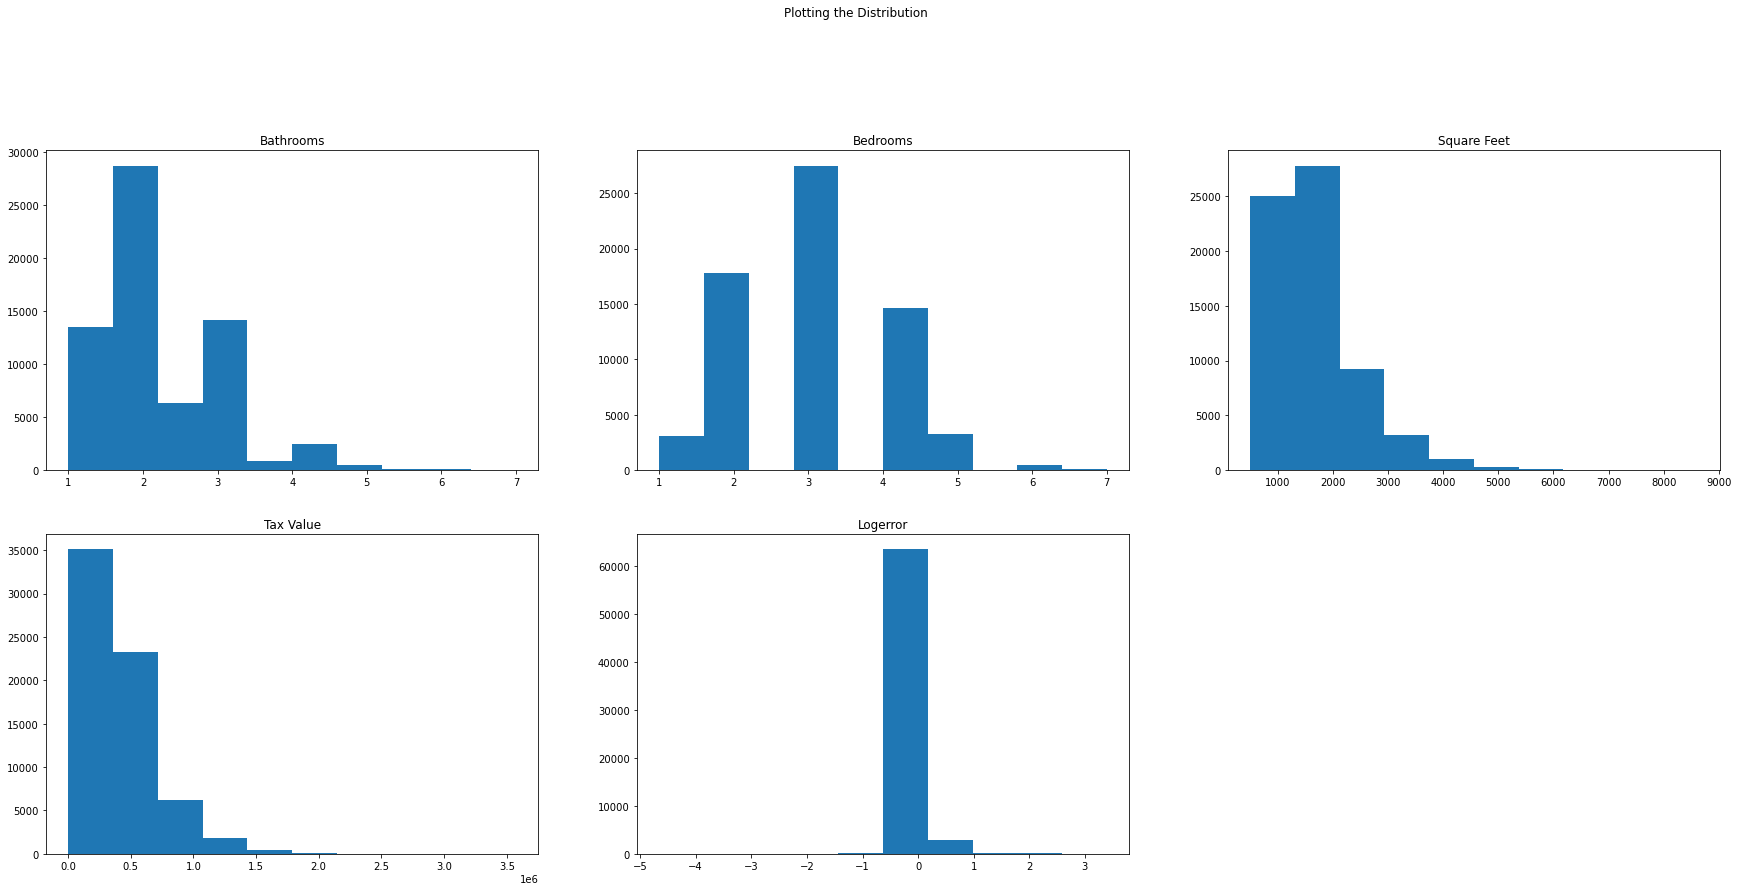

In [12]:
plt.figure(figsize=(30, 20))

plt.suptitle('Plotting the Distribution')

# row, column, index
plt.subplot(3,3,1)
plt.hist(df.bathrooms)
plt.title('Bathrooms')

plt.subplot(3,3,2)
plt.hist(df.bedrooms)
plt.title('Bedrooms')

plt.subplot(3,3,3)
plt.hist(df.square_feet)
plt.title('Square Feet')

plt.subplot(3,3,4)
plt.hist(df.tax_value)
plt.title('Tax Value')

plt.subplot(3,3,5)
plt.hist(df.logerror)
plt.title('Logerror')

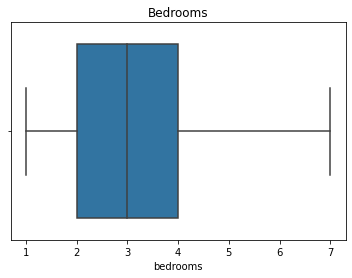

In [13]:
sns.boxplot(df.bedrooms)
plt.title('Bedrooms')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

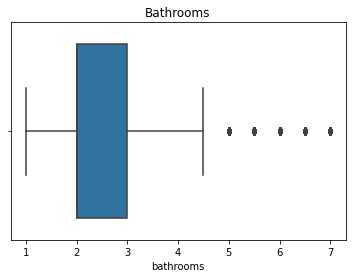

In [14]:
sns.boxplot(df.bathrooms)
plt.title('Bathrooms')
plt.show

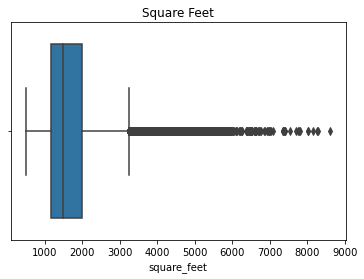

In [15]:
sns.boxplot(df.square_feet)
plt.title('Square Feet')
plt.show()

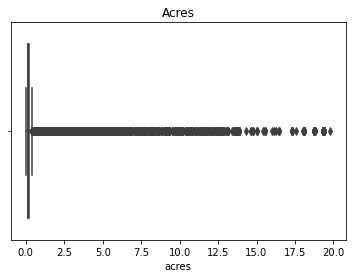

In [16]:
sns.boxplot(df.acres)
plt.title('Acres')
plt.show()

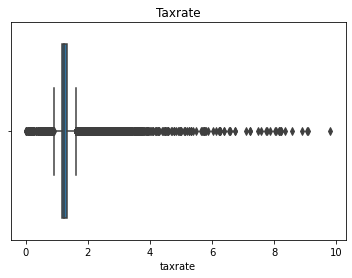

In [17]:
sns.boxplot(df.taxrate)
plt.title('Taxrate')
plt.show()

Takeaways for Prepare Data: <br>
- Nulls dropped
- Features added
- Definition of single residential properties (<=7 bedrooms, <=7 bathrooms, <=9000 sqft)



# Explore Data

In [18]:
# Split the data
train, validate, test = wrangle.train_validate_test_split(df)
print('Train: ', train.shape)
print('Validate: ', validate.shape)
print('Test: ', test.shape)

Train:  (40096, 24)
Validate:  (13366, 24)
Test:  (13366, 24)


Text(0.5, 1.0, 'Count vs Logerror')

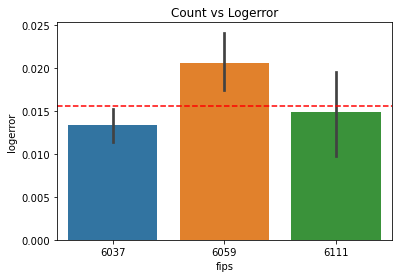

In [19]:
sns.barplot(train.fips, train.logerror, data=train)
mean_rate = train.logerror.mean()
plt.axhline(mean_rate, ls='--', color='red')
plt.title('Count vs Logerror')

ANOVA <br>
H0: county has no effect on logerror <br>
Ha: county does effect logerror <br> <br>
We reject H0

In [20]:
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.fips == 6037], train.logerror[train.fips == 6059], train.logerror[train.fips == 6111])
F, p

(7.640048724360329, 0.0004815053476957828)

Text(0.5, 1.0, 'Acres vs Log Error')

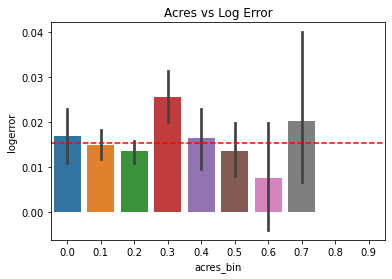

In [21]:
sns.barplot(train.acres_bin, train.logerror, data=train)
mean_rate = train.logerror.mean()
plt.axhline(mean_rate, ls='--', color='red')
plt.title('Acres vs Log Error')

Text(0.5, 1.0, 'Dollars per SQFT of Land vs Log Error')

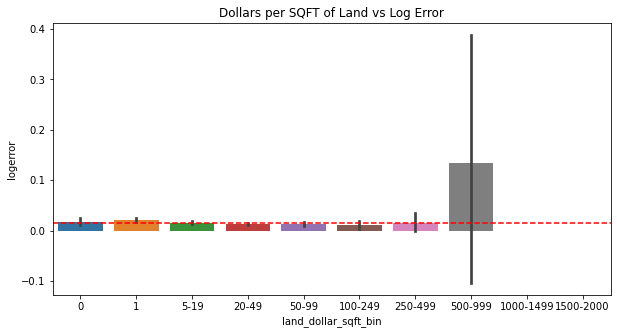

In [22]:
plt.figure(figsize=(10, 5))
sns.barplot(train.land_dollar_sqft_bin, train.logerror, data=train)
mean_rate = train.logerror.mean()
plt.axhline(mean_rate, ls='--', color='red')
plt.title('Dollars per SQFT of Land vs Log Error')

# Cluster Data

In [23]:
# Get rid of the binned features before further analysis
df = df.drop(columns=['taxrate','age_bin', 'acres_bin', 'tax_value_bin', 'land_tax_value_bin', 'sqft_bin', 'structure_dollar_sqft_bin', 'land_dollar_sqft_bin'])

# Get new train, validate, test sets that don't have binned features
train, validate, test = wrangle.train_validate_test_split(df)
train.head()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,logerror,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio
44803,3.0,3.0,2132.0,6037,3.388e+07,-1.184e+08,30.0,215909.0,455708.0,239799.0,5706.73,0.017,0.172,101.271,31.965,1.000
61849,2.0,4.0,1633.0,6111,3.426e+07,-1.187e+08,54.0,162000.0,456000.0,294000.0,5274.26,-0.044,0.199,99.204,33.832,0.500
65098,2.0,3.0,1927.0,6037,3.465e+07,-1.182e+08,40.0,154835.0,190296.0,35461.0,2930.22,-0.017,0.478,80.350,1.704,0.667
50488,2.5,3.0,1867.0,6059,3.384e+07,-1.178e+08,43.0,166023.0,565194.0,399171.0,6113.04,0.030,0.057,88.925,161.608,0.833
66689,1.5,3.0,1032.0,6059,3.383e+07,-1.180e+08,59.0,28831.0,52165.0,23334.0,841.86,-0.034,0.138,27.937,3.889,0.500


In [24]:
# Separate the target
# Scale the data
X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test = wrangle.scaled_data(train, validate, test)
X_train_scaled.shape, y_train.shape

((40096, 15), (40096, 1))

In [25]:
X_train_scaled.columns

Index(['bathrooms', 'bedrooms', 'square_feet', 'fips', 'latitude', 'longitude',
       'age', 'structure_tax_value', 'tax_value', 'land_tax_value',
       'taxamount', 'acres', 'structure_dollar_per_sqft',
       'land_dollar_per_sqft', 'bath_bed_ratio'],
      dtype='object')

In [26]:
y_train.columns

Index(['logerror'], dtype='object')

In [27]:
# Cluster using Kmeans

X = X_train_scaled

# Create the object
kmeans = KMeans(n_clusters = 4)

# Fit the object
kmeans.fit(X_train_scaled)

# Use the object
kmeans.predict(X_train_scaled)

array([1, 0, 1, ..., 3, 1, 1], dtype=int32)

In [28]:
X_train_scaled['cluster_all'] = kmeans.predict(X_train_scaled)
X_validate_scaled['cluster_all'] = kmeans.predict(X_validate_scaled)
X_test_scaled['cluster_all'] = kmeans.predict(X_test_scaled)

X_train_scaled.head()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cluster_all
0,0.333,0.333,0.210,0.000,0.363,0.577,0.213,0.075,0.127,0.239,0.102,0.008,0.085,0.047,0.286,1
1,0.167,0.500,0.145,1.000,0.625,0.378,0.390,0.057,0.127,0.293,0.094,0.010,0.083,0.050,0.107,0
2,0.167,0.333,0.183,0.000,0.889,0.664,0.287,0.054,0.052,0.034,0.052,0.024,0.067,0.003,0.167,1
3,0.250,0.333,0.176,0.297,0.339,0.897,0.309,0.058,0.157,0.398,0.109,0.002,0.074,0.239,0.226,2
4,0.083,0.333,0.068,0.297,0.334,0.757,0.426,0.010,0.014,0.022,0.015,0.006,0.023,0.006,0.107,2


In [29]:
X_train_scaled.cluster_all.value_counts()

1    21064
2     9848
3     5873
0     3311
Name: cluster_all, dtype: int64

<AxesSubplot:xlabel='latitude', ylabel='logerror'>

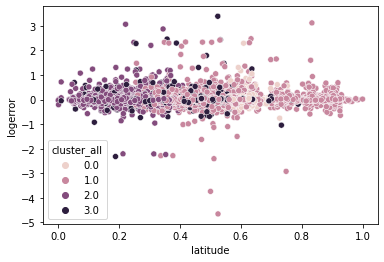

In [30]:
sns.scatterplot(x=X_train_scaled.latitude, y=y_train.logerror, hue=X_train_scaled.cluster_all)

<AxesSubplot:xlabel='acres', ylabel='logerror'>

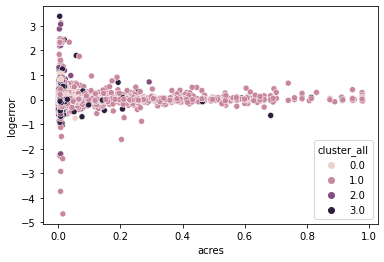

In [31]:
sns.scatterplot(x=X_train_scaled.acres, y=y_train.logerror, hue=X_train_scaled.cluster_all)

<AxesSubplot:xlabel='land_dollar_per_sqft', ylabel='logerror'>

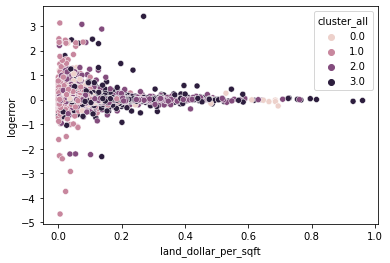

In [32]:
sns.scatterplot(x=X_train_scaled.land_dollar_per_sqft, y=y_train.logerror, hue=X_train_scaled.cluster_all)

<AxesSubplot:xlabel='age', ylabel='logerror'>

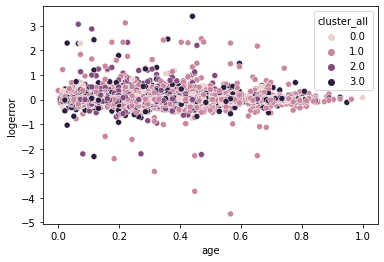

In [33]:
sns.scatterplot(x=X_train_scaled.age, y=y_train.logerror, hue=X_train_scaled.cluster_all)

<AxesSubplot:xlabel='fips', ylabel='logerror'>

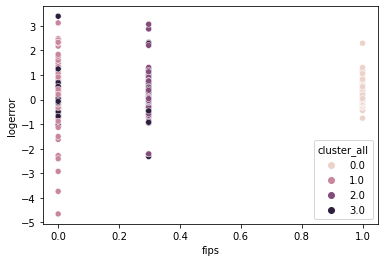

In [34]:
sns.scatterplot(x=X_train_scaled.fips, y=y_train.logerror, hue=X_train_scaled.cluster_all)

<AxesSubplot:xlabel='tax_value', ylabel='logerror'>

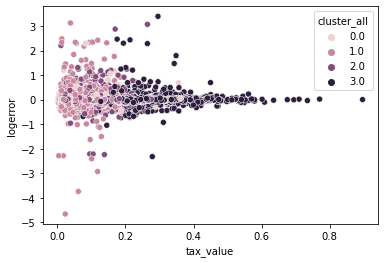

In [35]:
sns.scatterplot(x=X_train_scaled.tax_value, y=y_train.logerror, hue=X_train_scaled.cluster_all)

In [36]:
# Cluster based on location
X1 = X_train_scaled[['latitude', 'longitude', 'fips']]
X2 = X_validate_scaled[['latitude', 'longitude', 'fips']]
X3 = X_test_scaled[['latitude', 'longitude', 'fips']]

# Create the object
kmeans = KMeans(n_clusters=3)

# Fit the object
kmeans.fit(X1)

# Use the object
kmeans.predict(X1)

array([0, 1, 0, ..., 0, 0, 0], dtype=int32)

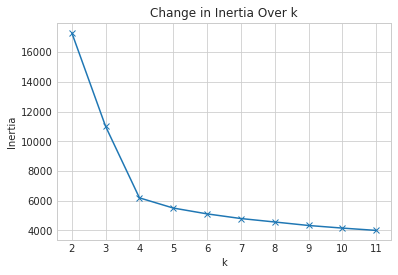

In [37]:
with plt.style.context('seaborn-whitegrid'):
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Change in Inertia Over k')

In [38]:
# Create new column for clusters by location
X_train_scaled['cluster_location'] = kmeans.predict(X1)
X_validate_scaled['cluster_location'] = kmeans.predict(X2)
X_test_scaled['cluster_location'] = kmeans.predict(X3)

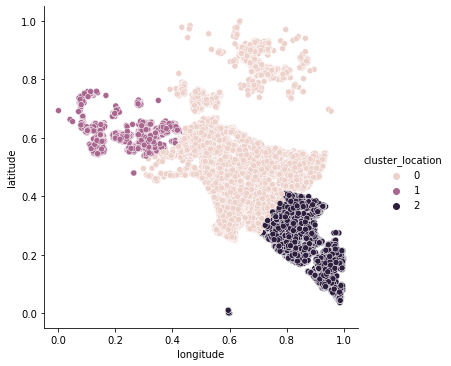

In [39]:
sns.relplot(x='longitude', y='latitude', hue='cluster_location', data=X_train_scaled)

In [40]:
# Cluster based on taxes
X1 = X_train_scaled[['structure_tax_value', 'land_tax_value', 'taxamount']]
X2 = X_validate_scaled[['structure_tax_value', 'land_tax_value', 'taxamount']]
X3 = X_test_scaled[['structure_tax_value', 'land_tax_value', 'taxamount']]

# Create the object
kmeans = KMeans(n_clusters=4)

# Fit the object
kmeans.fit(X1)

# Use the object
kmeans.predict(X1)

array([0, 0, 2, ..., 0, 2, 0], dtype=int32)

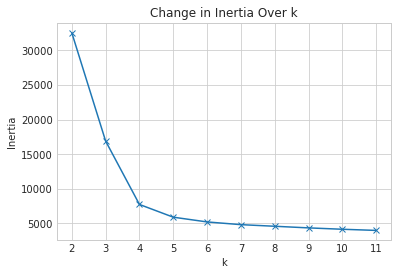

In [41]:
with plt.style.context('seaborn-whitegrid'):
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Change in Inertia Over k')

In [42]:
# Create new column for cluster by taxes
X_train_scaled['cluster_tax'] = kmeans.predict(X1)
X_validate_scaled['cluster_tax'] = kmeans.predict(X2)
X_test_scaled['cluster_tax'] = kmeans.predict(X3)

# Modeling

In [43]:
X_train_scaled = X_train_scaled.astype({'cluster_all':'category', 'cluster_location':'category', 'cluster_tax':'category'})

dummy_df = pd.get_dummies(X_train_scaled[['cluster_all', 'cluster_location', 'cluster_tax']])

In [44]:
X_validate_scaled = X_validate_scaled.astype({'cluster_all':'category', 'cluster_location':'category', 'cluster_tax':'category'})

dummy_df2 = pd.get_dummies(X_validate_scaled[['cluster_all', 'cluster_location', 'cluster_tax']])

In [45]:
X_test_scaled = X_test_scaled.astype({'cluster_all':'category', 'cluster_location':'category', 'cluster_tax':'category'})

dummy_df3 = pd.get_dummies(X_test_scaled[['cluster_all', 'cluster_location', 'cluster_tax']])

In [46]:
# Add dummy df columns to original df
X_train_scaled = pd.concat([X_train_scaled, dummy_df], axis=1)
X_validate_scaled = pd.concat([X_validate_scaled, dummy_df2], axis=1)
X_test_scaled = pd.concat([X_test_scaled, dummy_df3], axis=1)

X_train_scaled.head()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,age,structure_tax_value,tax_value,land_tax_value,taxamount,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio,cluster_all,cluster_location,cluster_tax,cluster_all_0,cluster_all_1,cluster_all_2,cluster_all_3,cluster_location_0,cluster_location_1,cluster_location_2,cluster_tax_0,cluster_tax_1,cluster_tax_2,cluster_tax_3
0,0.333,0.333,0.210,0.000,0.363,0.577,0.213,0.075,0.127,0.239,0.102,0.008,0.085,0.047,0.286,1,0,0,0,1,0,0,1,0,0,1,0,0,0
1,0.167,0.500,0.145,1.000,0.625,0.378,0.390,0.057,0.127,0.293,0.094,0.010,0.083,0.050,0.107,0,1,0,1,0,0,0,0,1,0,1,0,0,0
2,0.167,0.333,0.183,0.000,0.889,0.664,0.287,0.054,0.052,0.034,0.052,0.024,0.067,0.003,0.167,1,0,2,0,1,0,0,1,0,0,0,0,1,0
3,0.250,0.333,0.176,0.297,0.339,0.897,0.309,0.058,0.157,0.398,0.109,0.002,0.074,0.239,0.226,2,2,1,0,0,1,0,0,0,1,0,1,0,0
4,0.083,0.333,0.068,0.297,0.334,0.757,0.426,0.010,0.014,0.022,0.015,0.006,0.023,0.006,0.107,2,2,2,0,0,1,0,0,0,1,0,0,1,0


In [47]:
# Find the best predictors using KBest
k = 5
f_feature = wrangle.select_kbest(X_train_scaled, y_train, k)
f_feature
# cluster_living_conditions is redundant with bedrooms/bathrooms/square_feet

['bathrooms',
 'bedrooms',
 'square_feet',
 'structure_dollar_per_sqft',
 'cluster_location_2']

In [48]:
# Find the best predictors using RFE
k = 5
rfe_feature = wrangle.rfe(X_train_scaled, y_train, k)
rfe_feature

['cluster_location',
 'cluster_all_1',
 'cluster_all_3',
 'cluster_location_0',
 'cluster_location_2']

The most predictive features are: <br>
- bathrooms
- bedrooms
- square_feet
- structure_dollar_per_sqft
- cluster_all
- cluster_location

# Baseline Model

In [49]:
# Predict logerror_mean
y_train['logerror_pred_mean'] = y_train.logerror.mean()
y_validate['logerror_pred_mean'] = y_train.logerror.mean()

# Check baseline with RMSE
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean) ** 0.5

print('RMSE using Mean\nTrain/In-Sample: ', rmse_train, '\nValidate/Out-of-Sample: ', rmse_validate)

RMSE using Mean
Train/In-Sample:  0.1647985979741917 
Validate/Out-of-Sample:  0.15892196930696298


In [50]:
metric_df = pd.DataFrame(data=[{
    'model':'mean_baseline',
    'RMSE': rmse_validate,
    'r^2': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)
    }])

# Linear Regression Model (OLS)

In [51]:
# Create datasets with only the best features from KBest and RFE
X_train_small = X_train_scaled[['bedrooms', 'bathrooms', 'square_feet', 'structure_dollar_per_sqft', 'cluster_all', 'cluster_location']]
X_validate_small = X_validate_scaled[['bedrooms', 'bathrooms', 'square_feet', 'structure_dollar_per_sqft', 'cluster_all', 'cluster_location']]
X_test_small = X_test_scaled[['bedrooms', 'bathrooms', 'square_feet', 'structure_dollar_per_sqft', 'cluster_all', 'cluster_location']]

X_train_small.head()

,bedrooms,bathrooms,square_feet,structure_dollar_per_sqft,cluster_all,cluster_location
0,0.333,0.333,0.210,0.085,1,0
1,0.500,0.167,0.145,0.083,0,1
2,0.333,0.167,0.183,0.067,1,0
3,0.333,0.250,0.176,0.074,2,2
4,0.333,0.083,0.068,0.023,2,2


In [52]:
# Create the object
lm = LinearRegression(normalize=True)

# Fit the object
lm.fit(X_train_small, y_train.logerror)

# Use the object
y_train['logerror_pred_lm'] = lm.predict(X_train_small)
y_validate['logerror_pred_lm'] = lm.predict(X_validate_small)

# Check usig RMSE
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** 0.5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** 0.5

print('RMSE using Mean\nTrain/In-Sample: ', rmse_train, '\nValidate/Out-of-Sample: ', rmse_validate)

RMSE using Mean
Train/In-Sample:  0.16453966952601276 
Validate/Out-of-Sample:  0.1587501191753389


In [53]:
metric_df = metric_df.append({
    'model':'OLS',
    'RMSE': rmse_validate,
    'r^2': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)},
    ignore_index=True)

# Lasso + LARS Model

In [54]:
# Create the object
lars = LassoLars(alpha=1)

# Fit the object
lars.fit(X_train_small, y_train.logerror)

# Use the object
y_train['logerror_pred_lars'] = lars.predict(X_train_small)
y_validate['logerror_pred_lars'] = lars.predict(X_validate_small)

# Check usig RMSE
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars) ** 0.5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars) ** 0.5

print('RMSE using Mean\nTrain/In-Sample: ', rmse_train, '\nValidate/Out-of-Sample: ', rmse_validate)

RMSE using Mean
Train/In-Sample:  0.1647985979741917 
Validate/Out-of-Sample:  0.15892196930696298


In [55]:
metric_df = metric_df.append({
    'model':'LassoLars',
    'RMSE': rmse_validate,
    'r^2': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lars)},
    ignore_index=True)

# Polynomial Regression Model

In [56]:
# Create new polynomial features
pf = PolynomialFeatures(degree=2)

# Create the object
X_train_degree = pf.fit_transform(X_train_small)

# Fit the object and transform the data
X_validate_degree = pf.transform(X_validate_small)

# Create the model object
lm2 = LinearRegression(normalize=True)

# Fit the object
lm2.fit(X_train_degree, y_train.logerror)

# Use the object
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree)
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree)

# Check usig RMSE
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2) ** 0.5
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2) ** 0.5

print('RMSE using Mean\nTrain/In-Sample: ', rmse_train, '\nValidate/Out-of-Sample: ', rmse_validate)

RMSE using Mean
Train/In-Sample:  0.16438871143609854 
Validate/Out-of-Sample:  0.15875136637797696


In [57]:
metric_df = metric_df.append({
    'model':'Polynomial',
    'RMSE': rmse_validate,
    'r^2': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm2)},
    ignore_index=True)

In [58]:
metric_df

,model,RMSE,r^2
0,mean_baseline,0.159,1.110e-16
1,OLS,0.159,2.155e-03
2,LassoLars,0.159,1.110e-16
3,Polynomial,0.159,2.133e-03


The polynomial model appears to be the best model

# Model on Test Data Subset

In [59]:
X_test_degree = pf.transform(X_test_small)
y_test['logerror_pred_lm2'] = lm2.predict(X_test_degree)

# Check usig RMSE
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm2) ** 0.5

print('RMSE using Test/Out-of-Sample: ', rmse_test)

RMSE using Test/Out-of-Sample:  0.15736760747842432


In [60]:
metric_df = metric_df.append({
    'model':'Polynomial Test Set',
    'RMSE': rmse_test,
    'r^2': explained_variance_score(y_test.logerror, y_test.logerror_pred_lm2)},
    ignore_index=True)

In [61]:
metric_df

,model,RMSE,r^2
0,mean_baseline,0.159,1.110e-16
1,OLS,0.159,2.155e-03
2,LassoLars,0.159,1.110e-16
3,Polynomial,0.159,2.133e-03
4,Polynomial Test Set,0.157,2.694e-03


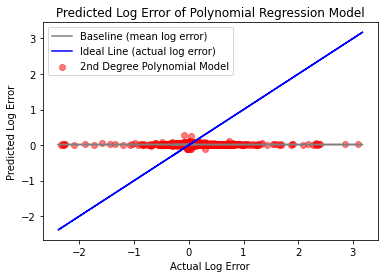

In [62]:
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, color='gray', label='Baseline (mean log error)')
plt.plot(y_validate.logerror, y_validate.logerror, color='blue', label='Ideal Line (actual log error)')
plt.scatter(y_test.logerror, y_test.logerror_pred_lm2, alpha=0.5, color='red', label='2nd Degree Polynomial Model')
plt.legend()
plt.xlabel('Actual Log Error')
plt.ylabel('Predicted Log Error')
plt.title('Predicted Log Error of Polynomial Regression Model')
plt.show()


Takeaways: <br>
- KBest found bathrooms to be the most predictive feature
- RFE found cluster_location to be the most predictive feature
- Polynomial regression provided the best model
- The models performed similar to the mean baseline, and did not outperform the baseline

# Conclusion <br>
None of the models provided better predictions than the mean baseline. This could be for many reasons: <br>
- The general difficulty of modeling human behavior in complex socioeconimic environments
- Methods of preparing data were too harsh and unintentionally removed important data
- Better predictive features must be identified <br> <br>
Given more time I would like to search for more predictive features or engineered features